In [1]:
import pandas as pd
import numpy as np
import os, cv2, random, pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm



/home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
size = 224
training_data = []



In [3]:
#create import function 
def image_import (img_path, class_type, appended_list):
    for i in os.listdir(img_path):
        read_path = os.path.join(img_path, i)
       # print(i)
        try:
            img = cv2.imread(read_path)
            img = cv2.resize(img, (size, size))
            appended_list.append([img, class_type])
        except Exception as e:
            print(f'Image error: {i}')
            pass



In [4]:

train_dir = "data/X-ray_dataset_old/chest_xray/train"
test_dir = "data/X-ray_dataset_old/chest_xray/test"
val_dir = "data/X-ray_dataset_old/chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")
NUM_IMAGES = num_pneumonia+num_normal

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

#import pneumonia images
img_path = 'data/X-ray_dataset_old/chest_xray/train/PNEUMONIA'
image_import(img_path,1, training_data)



Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


In [5]:
#import normal lung images
img_path = 'data/X-ray_dataset_old/chest_xray/train/NORMAL'
image_import(img_path, 0, training_data)



In [6]:
#shuffle training data
random.shuffle(training_data)



In [7]:
#seperate XY
features = []
targets = []

for f, t in training_data:
    features.append(f)
    targets.append(t)

X = np.array(features).reshape(-1, size, size, 3)
Y = np.array(targets)

In [8]:
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        validation_split=0.2,
        brightness_range=[0.2,1.0],)
test_img = datagen.flow(
    X,
    Y,
    subset="training")
val_img = datagen.flow(
    X,
    Y,
    subset="validation")

In [9]:
#MobileNetV2 model
base_model=tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling=max,
    #classifier_activation="softmax",
    #**kwargs
)
base_model.trainable = False


W1216 15:54:15.418107 139851566425920 deprecation.py:506] From /home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
#build model
model = Sequential()  
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.add(Activation('sigmoid'))
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


W1216 15:26:30.770354 140272550463296 deprecation.py:323] From /home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [40]:
#train model
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)
model.fit(test_img, batch_size = 32, epochs = 12,validation_data = val_img)



Epoch 1/12
131/131 [==============================] - 131s 1s/step - loss: 0.4309 - acc: 0.8176 - val_loss: 0.2243 - val_acc: 0.9147
Epoch 2/12
131/131 [==============================] - 142s 1s/step - loss: 0.2689 - acc: 0.8910 - val_loss: 0.2448 - val_acc: 0.8907
Epoch 3/12
131/131 [==============================] - 134s 1s/step - loss: 0.2270 - acc: 0.9075 - val_loss: 0.2183 - val_acc: 0.9099
Epoch 4/12
131/131 [==============================] - 133s 1s/step - loss: 0.2375 - acc: 0.9068 - val_loss: 0.2358 - val_acc: 0.9060
Epoch 5/12
131/131 [==============================] - 133s 1s/step - loss: 0.2121 - acc: 0.9145 - val_loss: 0.1690 - val_acc: 0.9396
Epoch 6/12
131/131 [==============================] - 143s 1s/step - loss: 0.2137 - acc: 0.9142 - val_loss: 0.1872 - val_acc: 0.9223
Epoch 7/12
131/131 [==============================] - 150s 1s/step - loss: 0.1927 - acc: 0.9288 - val_loss: 0.1829 - val_acc: 0.9262
Epoch 8/12
131/131 [==============================] - 134s 1s/step - 

In [41]:
model.save('pneumonia_cnn.model')

In [7]:
#import pneumonia testng data
img_path = 'data/X-ray_dataset_old/chest_xray/test/PNEUMONIA'
testing_data=[]
image_import(img_path, 1, testing_data)


In [8]:


#import normal lung testing data
img_path = 'data/X-ray_dataset_old/chest_xray/test/NORMAL'
image_import(img_path,0, testing_data)



In [9]:
#shuffle training_data
random.shuffle(testing_data)

In [10]:
#seperate testing to XY
test_features = []
test_targets = []

for f, t in testing_data:
    test_features.append(f)
    test_targets.append(t)

test_features = np.array(test_features).reshape(-1, size, size, 3)
test_targets = np.array(test_targets)   
test_features = test_features/255
X_test = np.array(test_features).reshape(-1, size, size, 3)
Y_test = np.array(test_targets)


In [11]:


#confusion matrix calculation
false_negative = 0
false_positive = 0
true_negative = 0
true_positive = 0

model = tf.keras.models.load_model('pneumonia_cnn.model')
result = model.predict_classes(test_features)
accuracy = model.evaluate(test_features,test_targets)[1]

for i in range(len(test_features)):
    if test_targets[i] == 1:
        if result[i] == 1:
            true_positive += 1
        elif result[i] == 0: 
            false_negative += 1
        else:
            print('error class not found')
    if test_targets[i] == 0:
        if result[i] == 1:
            false_positive += 1
        elif result[i] == 0: 
            true_negative += 1
        else:
            print('error class not found')
            



W1218 19:01:07.126194 140016708384576 deprecation.py:506] From /home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1218 19:01:07.127332 140016708384576 deprecation.py:506] From /home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1218 19:01:07.128048 140016708384576 deprecation.py:506] From /home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.pyt

624/624 [==============================] - 3s 5ms/sample - loss: 0.3912 - acc: 0.9006


In [12]:
#create confusion matrix data
test_result = [false_negative,
               true_negative,
              true_positive,
               false_positive]
adjusted_test_result = np.array(test_result)/(len(test_features))
df_test_result = pd.DataFrame(np.array(['false_negative','true_negative','true_positive','false_positive']),columns=['results'])
df_test_result['percent'] = adjusted_test_result
df_test_result



,results,percent
0,false_negative,0.022436
1,true_negative,0.298077
2,true_positive,0.602564
3,false_positive,0.076923


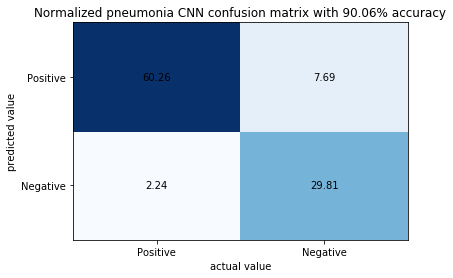

In [13]:


#confusion matrix plot 
fig,ax = plt.subplots()
heatmap = ax.pcolor((df_test_result['percent'].to_numpy().reshape(2,2)),cmap='Blues')
data = df_test_result['percent'].to_numpy().reshape(2,2)* 100
for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        ax.text(x + 0.5, y + 0.5, '%.2f' % data[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
ax.set_xticks([0.5,1.5])
ax.set_yticks([0.5,1.5])
ax.set_xticklabels(['Positive','Negative'])
ax.set_yticklabels(['Negative','Positive'])
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.title('Normalized pneumonia CNN confusion matrix with %.2f' %(accuracy*100)+ '% accuracy')
plt.savefig('accuracy_model_original_data.png')
plt.show()

